In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db=mysql.connector.connect(host= "localhost",
                           username="root",
                           password="2552",
                           database="Ecommerce") 

cur= db.cursor()

List all unique cities where customers are located.

In [76]:
cur.execute("Select distinct customer_city from customers")
data=cur.fetchall()
df= pd.DataFrame(data, columns =["Cities"])
df


,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


Count the number of orders placed in 2017.

In [23]:
cur.execute("Select count(order_id) from orders where year(order_purchase_timestamp)=2017")
data=cur.fetchall()
print(data)

[(45101,)]


Find the total sales per category.

In [25]:
cur.execute("select products.product_category,sum(payments.payment_value) from products join order_items on products.product_id=order_items.product_id join payments on payments.order_id=order_items.order_id group by products.product_category ")
data=cur.fetchall()
df= pd.DataFrame(data, columns=["Categories","Sales"])
print(df)

                     Categories         Sales
0                     perfumery  5.067387e+05
1          Furniture Decoration  1.430176e+06
2                     telephony  4.868821e+05
3                bed table bath  1.712554e+06
4                    automotive  8.522943e+05
..                          ...           ...
69               cds music dvds  1.199430e+03
70                   La Cuisine  2.913530e+03
71  Fashion Children's Clothing  7.856700e+02
72                     PC Gamer  2.174430e+03
73       insurance and services  3.245100e+02

[74 rows x 2 columns]


Calculate the percentage of orders that were paid in installments.

In [27]:
cur.execute("Select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments")
data=cur.fetchall()
print(data)

[(Decimal('99.9981'),)]


Count the number of customers from each state.

   State  Count
0     SP  41746
4     RJ  12852
2     MG  11635
5     RS   5466
3     PR   5045
1     SC   3637
9     BA   3380
13    DF   2140
8     ES   2033
7     GO   2020
15    PE   1652
12    CE   1336
6     PA    975
16    MT    907
10    MA    747
11    MS    715
21    PB    536
23    PI    495
14    RN    485
19    AL    413
25    SE    350
22    TO    280
20    RO    253
17    AM    148
24    AC     81
18    AP     68
26    RR     46


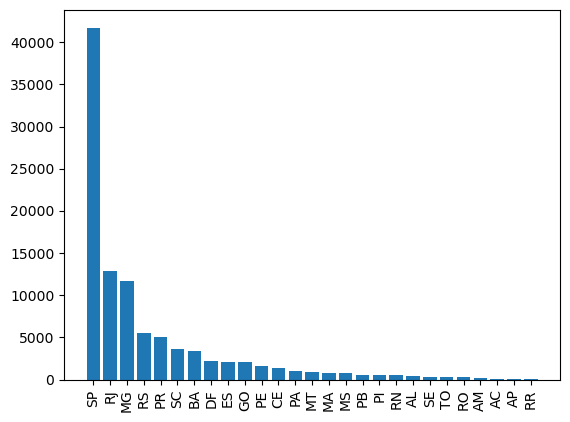

In [29]:
cur.execute("Select customer_state,count(customer_id) from customers group by customer_state")
data=cur.fetchall()
df= pd.DataFrame(data,columns=["State","Count"])
df=df.sort_values(by= ["Count"],ascending=False)
print(df)
plt.bar(df["State"],df["Count"])
plt.xticks(rotation= 90)
plt.show()


Calculate the number of orders per month in 2018.

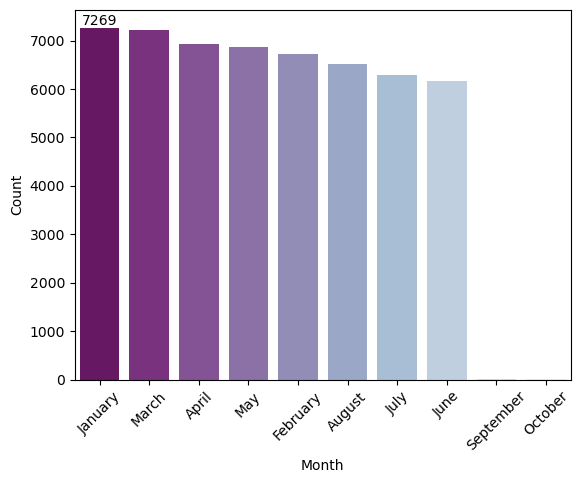

In [70]:
cur.execute("Select monthname(order_purchase_timestamp) as months, count(order_id) from orders where year(order_purchase_timestamp)=2018 group by months")
data=cur.fetchall()
df= pd.DataFrame(data,columns=["Month","Count"])
df=df.sort_values(by= ["Count"],ascending=False)
ax=sns.barplot(x="Month",y="Count",data=df, hue="Month",palette="BuPu_r")
plt.xticks(rotation= 45)
ax.bar_label(ax.containers[0])
plt.show()

Find the average number of products per order, grouped by customer city.

In [33]:
cur.execute("with count_per_order as(Select orders.order_id,orders.customer_id,count(order_items.order_id) as oc from orders join order_items on orders.order_id = order_items.order_id group by orders.order_id,orders.customer_id) Select customers.customer_city, round(avg(count_per_order.oc),2) as avg_orders from customers join count_per_order on customers.customer_id = count_per_order.customer_id group by customers.customer_city order by avg_orders desc")
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_city", "average_products_per_order"])
df.head(10)

,customer_city,average_products_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


Calculate the percentage of total revenue contributed by each product category.

In [35]:
cur.execute("select products.product_category,round(((sum(payments.payment_value))/( select sum(payment_value) from payments)* 100),2) as percentage_payments_per_product from products join order_items on products.product_id=order_items.product_id join payments on payments.order_id=order_items.order_id group by products.product_category order by percentage_payments_per_product desc")
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Product", "Percentage of Total Payments"])
df.head(10)

,Product,Percentage of Total Payments
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


Identify the correlation between product price and the number of times a product has been purchased.

In [37]:
cur.execute("select products.product_category, count(order_items.product_id), round(avg(order_items.price),2) from products join order_items on products.product_id = order_items.product_id group by products.product_category")
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Product", "Product count","Price"])
df
arr1= df["Product count"]
arr2= df["Price"]
a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is",a[0,1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


Calculate the total revenue generated by each seller, and rank them by revenue.

In [39]:
cur.execute("select *,  dense_rank() over (order by revenue desc) from (select order_items.seller_id, round(sum(payments.payment_value),2) as revenue from order_items join payments on order_items.order_id = payments.order_id group by order_items.seller_id) as a")
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Seller ID", "Revenue","Rank"])
df

,Seller ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


Calculate the moving average of order values for each customer over their order history.

In [41]:
cur.execute("Select customer_id, order_purchase_timestamp, payment, avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from (select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment from payments join orders on payments.order_id = orders.order_id) as a")
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer ID", "Order Timestamp","Payment","Moving Average"])
df

,Customer ID,Order Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


 Calculate the cumulative sales per month for each year

In [43]:
cur.execute("select years, months, payments, sum(payments) over(order by years,months) as cumulative_pay from (Select year( orders.order_purchase_timestamp) as years, month( orders.order_purchase_timestamp) as months, round(sum(payments.payment_value),2) as payments from payments join orders on payments.order_id = orders.order_id group by years, months order by years,months) as a")
data= cur.fetchall()
df= pd.DataFrame(data, columns= [" Years", "Months", "Payments"," Cumulative Pay"])
df            

,Years,Months,Payments,Cumulative Pay
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


Calculate the year-over-year growth rate of total sales.

In [45]:
cur.execute("with a as (Select year( orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) as payments from payments join orders on payments.order_id = orders.order_id group by years order by years ) select years, payments,((payments - lag(payments,1) over(order by years))/ lag(payments,1) over(order by years)) * 100 from a")
data= cur.fetchall()
df= pd.DataFrame(data, columns= [" Years", "Payments","Year by Year Growth %"])
df  

,Years,Payments,Year by Year Growth %
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

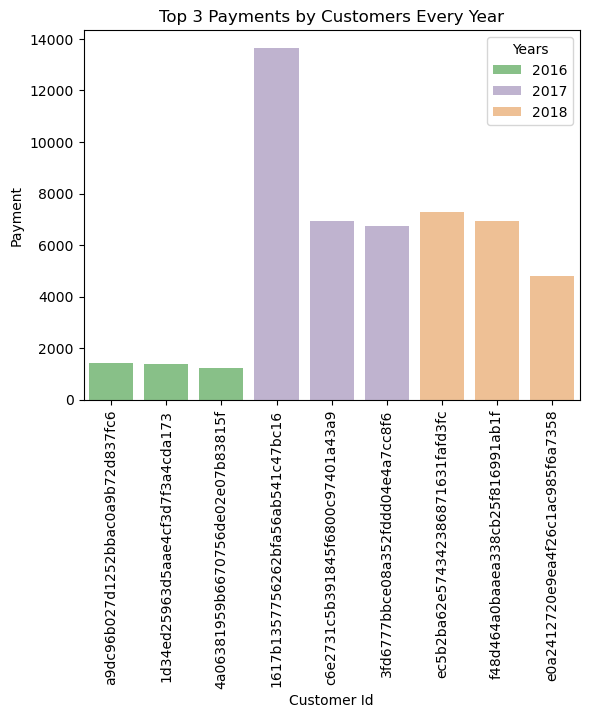

In [47]:
cur.execute("select years,customer_id, payment,d_rank from (select year(orders.order_purchase_timestamp) as years, orders.customer_id, sum(payments.payment_value) as payment, dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank from payments join orders on payments.order_id = orders.order_id group by years, orders.customer_id order by years) as a where d_rank <= 3")
data=cur.fetchall()
df= pd.DataFrame(data, columns = ["Years","Customer Id","Payment","Rank"])
sns.barplot(x="Customer Id", y="Payment", data= df, hue= "Years", palette="Accent")
plt.title('Top 3 Payments by Customers Every Year')
plt.xticks( rotation = 90)